## Adjust infilled LGM SST/SIC files for use as CAM boundary condition.

#### Author: Vince Cooper, referencing scripts from Yue Dong and Cecile Hannay

In [47]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import copy
import pandas as pd

In [48]:
##### Load original data from U Arizona team for reference only #####

## Load LGM output
ddir = '/home/disk/atmos/vcooper/work/p2c2/lgm/'
dfile = 'lgmDA_hol_SST_monthly_climo.nc'
ncf = ddir + dfile
tempds = xr.open_dataset(ncf)
tempds = xr.merge([tempds.set_coords(['lat','lon','month']).sst,
                   tempds.set_coords(['lat','lon','month']).sst_std])
holo_sst_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
holo_sst_climo['mask'] = xr.where(~np.isnan(holo_sst_climo.sst.isel(nmonth=0)), 1, 0)

dfile = 'lgmDA_lgm_SST_monthly_climo.nc'
ncf = ddir + dfile
tempds = xr.open_dataset(ncf)
tempds = xr.merge([tempds.set_coords(['lat','lon','month']).sst,
                   tempds.set_coords(['lat','lon','month']).sst_std])
lgm_sst_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
lgm_sst_climo['mask'] = xr.where(~np.isnan(lgm_sst_climo.sst.isel(nmonth=0)), 1, 0)

## Load ICEFRAC
dfile = 'lgmDA_hol_ICEFRAC_monthly_climo.nc'
ncf = ddir + dfile
tempds = xr.open_dataset(ncf)
tempds = xr.merge([tempds.set_coords(['lat','lon','month']).icefrac,
                   tempds.set_coords(['lat','lon','month']).icefrac_std])
holo_ice_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
holo_ice_climo['mask'] = xr.where(~np.isnan(holo_ice_climo.icefrac.isel(nmonth=0)), 1, 0)

dfile = 'lgmDA_lgm_ICEFRAC_monthly_climo.nc'
ncf = ddir + dfile
tempds = xr.open_dataset(ncf)
tempds = xr.merge([tempds.set_coords(['lat','lon','month']).icefrac,
                   tempds.set_coords(['lat','lon','month']).icefrac_std])
lgm_ice_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
lgm_ice_climo['mask'] = xr.where(~np.isnan(lgm_ice_climo.icefrac.isel(nmonth=0)), 1, 0)

In [49]:
## load infilled version
path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
lgm_sst_merged = xr.open_dataset(path + 
                                     'lgmDA_lgm_SST_monthly_climo_merged.nc')

lgm_ice_merged = xr.open_dataset(path + 'lgmDA_lgm_ICEFRAC_monthly_climo_merged_v2.nc').set_coords(['lat','lon'])

## load modern day AMIP SSTs and SIC
## currently using the 1.9x2.5 version since that matches resolution of received icefrac data
path = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
amip2000 = xr.open_dataset(path + 'sst_HadOIBl_bc_1.9x2.5_clim_c061031.nc',decode_times=False)
# amip2000 = xr.open_dataset(path + 'sst_HadOIBl_bc_0.9x1.25_clim_c040926.nc',decode_times=False)

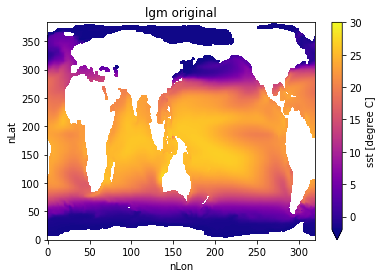

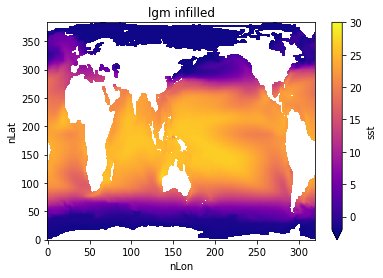

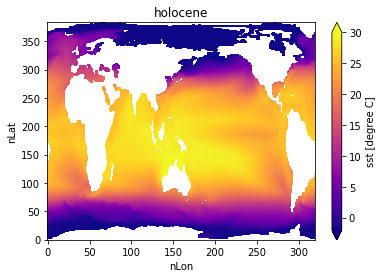

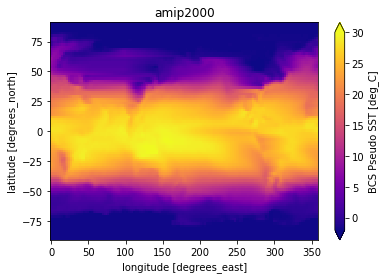

In [50]:
## quick look at various grids
lgm_sst_climo.sst[0].plot(cmap='plasma',vmin=-2,vmax=30)
plt.title('lgm original')
plt.show()

lgm_sst_merged.sst[0].plot(cmap='plasma',vmin=-2,vmax=30)
plt.title('lgm infilled')
plt.show()

holo_sst_climo.sst[0].plot(cmap='plasma',vmin=-2,vmax=30)
plt.title('holocene')
plt.show()

amip2000.SST_cpl[0].plot(cmap='plasma',vmin=-2,vmax=30)
plt.title('amip2000')
plt.show()

### Regrid LGM onto amip grid with values over land

In [51]:
%%time
## SST (icefrac is already on 1.9x2.5 grid)
amip2000['mask'] = xr.where(~np.isnan(amip2000.SST_cpl[0]),1,0) ## dummy mask
newgrid = amip2000 # desired grid
data_for_regridding = lgm_sst_merged
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst[0]),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,extrap_num_src_pnts=64,
                         extrap_method='inverse_dist',
#                          filename='bilinear_lgm_to_holo_per_extrapID64.nc',
                         reuse_weights=False)

lgm_sst_amipgrid = regridder(lgm_sst_merged)
holo_sst_amipgrid = regridder(holo_sst_climo)

regridder

/home/disk/atmos/vcooper/miniconda3/envs/beauchard/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


CPU times: user 4.88 s, sys: 169 ms, total: 5.05 s
Wall time: 5.42 s


/home/disk/atmos/vcooper/miniconda3/envs/beauchard/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_384x320_96x144_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (384, 320) 
Output grid shape:          (96, 144) 
Periodic in longitude?      True

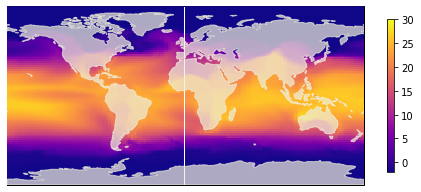

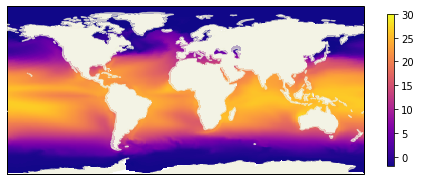

In [52]:
## spot check sst
## infilled, regridded to amip2000 (now has values over land)
plt.figure(figsize=(8,4))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.pcolormesh(lgm_sst_amipgrid.lon,lgm_sst_amipgrid.lat,
               lgm_sst_amipgrid.sst[0],cmap='plasma',vmin=-2,vmax=30,
               transform=ccrs.PlateCarree(),zorder=3)
ax.add_feature(cfeature.LAND,zorder=5,alpha=0.7)
plt.colorbar(shrink=0.7)
plt.show()

## infilled, before regridding
plt.figure(figsize=(8,4))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.pcolormesh(lgm_sst_merged.lon,lgm_sst_merged.lat,
               lgm_sst_merged.sst[0],cmap='plasma',vmin=-2,vmax=30,
               transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,zorder=5,alpha=0.7)
plt.colorbar(shrink=0.7)
plt.show()

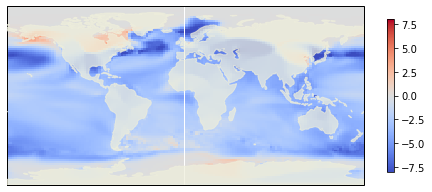

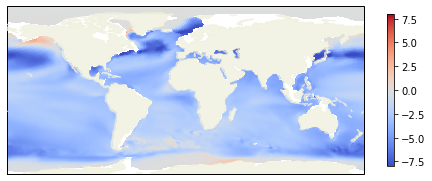

In [53]:
## spot check sst anomaly

## regridded anomaly on AMIP grid
plt.figure(figsize=(8,4))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.pcolormesh(lgm_sst_amipgrid.lon,lgm_sst_amipgrid.lat,
               lgm_sst_amipgrid.sst[0] - holo_sst_amipgrid.sst[0],cmap='coolwarm',vmin=-8,vmax=8,
               transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,zorder=5,alpha=0.7)
plt.colorbar(shrink=0.7)
plt.show()

## original anomaly from Jess 
plt.figure(figsize=(8,4))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.pcolormesh(lgm_sst_climo.lon,lgm_sst_climo.lat,
               lgm_sst_climo.sst[0] - holo_sst_climo.sst[0],cmap='coolwarm',vmin=-8,vmax=8,
               transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,zorder=5,alpha=0.7)
plt.colorbar(shrink=0.7)
plt.show()

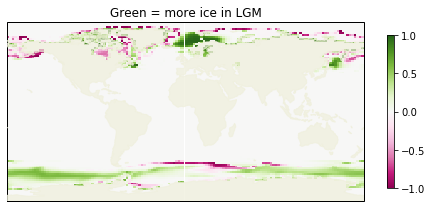

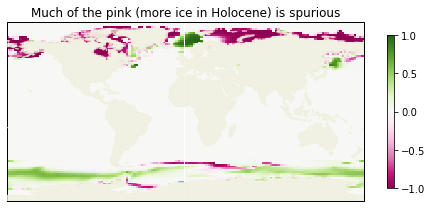

In [54]:
## plots to check icefrac too, although no changes made

## infilled anomaly on AMIP grid
plt.figure(figsize=(8,4))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.pcolormesh(lgm_ice_merged.lon,lgm_ice_merged.lat,
               lgm_ice_merged.icefrac[0] - holo_ice_climo.icefrac[0],cmap='PiYG',vmin=-1,vmax=1,
               transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,zorder=5,alpha=0.7)
plt.colorbar(shrink=0.7)
plt.title('Green = more ice in LGM')
plt.show()

## original anomaly from U Arizona 
plt.figure(figsize=(8,4))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.pcolormesh(lgm_ice_merged.lon,lgm_ice_merged.lat,
               lgm_ice_climo.icefrac[0] - holo_ice_climo.icefrac[0],cmap='PiYG',vmin=-1,vmax=1,
               transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,zorder=5,alpha=0.7)
plt.title('Much of the pink (more ice in Holocene) is spurious')
plt.colorbar(shrink=0.7)
plt.show()

# Create merged dataset and preprocess

### Following create_SST_files_from_B_case_with_bcgen.ncl

#### ncl code adapted for python

In [55]:
## dummy code to preserve amip dataset attributes etc but use our lgm values
lgm_sst_bc_prediddle = lgm_sst_amipgrid.sst.values + amip2000.SST_cpl_prediddle - amip2000.SST_cpl_prediddle
lgm_ice_bc_prediddle = lgm_ice_merged.icefrac.values + amip2000.ice_cov_prediddle - amip2000.ice_cov_prediddle

holo_sst_bc_prediddle = holo_sst_amipgrid.sst.values + amip2000.SST_cpl_prediddle - amip2000.SST_cpl_prediddle
holo_ice_bc_prediddle = holo_ice_climo.icefrac.values + amip2000.ice_cov_prediddle - amip2000.ice_cov_prediddle

In [56]:
def data_consistency_before_bcgen(sst_prediddle,sic_prediddle):
    
    ## this function has the reference code from ncl script for each step
    
    # 1) If SST < -1.8 or ice frac >= 90%, SST = -1.8
    # SST = where(SST.le.-1.8, -1.8, SST)
    # SST = where(SEAICE.gt.90., -1.8, SST)

    sst_prediddle_adj = xr.where(sst_prediddle < -1.8, 
                                        -1.8, sst_prediddle)
    sst_prediddle_adj = xr.where(sic_prediddle > 0.9, 
                                        -1.8, sst_prediddle_adj)

    # ; 2) min ice frac is 0%, max ice_frac is 100%
    # SEAICE = where(SEAICE.lt.0., 0., SEAICE)
    # SEAICE = where(SEAICE.gt.100., 100., SEAICE)
    sic_prediddle_adj = xr.where(sic_prediddle < 0, 
                                        0, sic_prediddle)
    sic_prediddle_adj = xr.where(sic_prediddle_adj > 1, 
                                        1, sic_prediddle_adj)

    # ; 3) Hurrell et al correction to SST (if 0.15 < ice frac < 0.9)
    # SST_max = 9.328*(0.729-(SEAICE/100.)^3)-1.8
    # SST = where((SEAICE.gt.15.).and.(SEAICE.lt.90.).and.(SST.gt.SST_max), SST_max, SST)
    SST_max = 9.328*(0.729-(sic_prediddle_adj)**3)-1.8
    sst_prediddle_adj = xr.where((sic_prediddle_adj > 0.15) & 
                                        (sic_prediddle_adj < 0.90) &
                                        (sst_prediddle_adj > SST_max), 
                                         SST_max, sst_prediddle_adj)

    # ; 4) No sea ice if SST > 4.97
    # SEAICE = where(SST.gt.4.97, 0., SEAICE)
    sic_prediddle_adj = xr.where(sst_prediddle_adj > 4.97, 
                                        0, sic_prediddle_adj)

    # ; 5) Hurrell et al correction to ice frac (if -1.8 < SST < 4.97)
    # ice_max = 100.*(0.729-(SST+1.8)/9.328)^(1./3.)
    # SEAICE = where((SST.gt.-1.8).and.(SST.lt.4.97).and.(SEAICE.gt.ice_max), ice_max, SEAICE)
    ice_max = (0.729-(sst_prediddle_adj+1.8)/9.328)**(1./3.)
    sic_prediddle_adj = xr.where((sst_prediddle_adj > -1.8) & 
                                        (sst_prediddle_adj < 4.97) & 
                                        (sic_prediddle_adj > ice_max), 
                                         ice_max, sic_prediddle_adj)

    # print((/"Filling in missing values in SST and SEAICE..."/))
    # poisson_grid_fill(SST, True, 1, 500, 0.01, 0.6, 0)
    # poisson_grid_fill(SEAICE, True, 1, 500, 0.01, 0.6, 0)
    ##  VTC: don't need this step because already extrapolated by regridding
    ##       but should check whether these land values are actually used?
    
    return(sst_prediddle_adj, sic_prediddle_adj)

In [57]:
## adjust values for lgm and holocene
lgm_sst_bc_prediddle_adj, lgm_ice_bc_prediddle_adj = data_consistency_before_bcgen(lgm_sst_bc_prediddle,
                                                                                   lgm_ice_bc_prediddle)

holo_sst_bc_prediddle_adj, holo_ice_bc_prediddle_adj = data_consistency_before_bcgen(holo_sst_bc_prediddle,
                                                                                     holo_ice_bc_prediddle)

## Next step is to use the bcgen script for time diddling

## But for now, we will skip it and just get the file ready

In [58]:
## use the pre-made CAM SST/SIC file, and just replace the values with our LGM values
## currently using the 1.9x2.5 version since that matches resolution of received icefrac data
path = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
amip2000 = xr.open_dataset(path + 'sst_HadOIBl_bc_1.9x2.5_clim_c061031.nc',decode_times=False)

## amip2000 is what we mimic
amip2000

<xarray.Dataset>
Dimensions:            (time: 12, lon: 144, lat: 96)
Coordinates:
  * lon                (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * lat                (lat) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * time               (time) float64 15.5 45.0 74.5 105.0 ... 288.5 319.0 349.5
Data variables:
    date               (time) int32 ...
    datesec            (time) int32 ...
    ice_cov            (time, lat, lon) float32 ...
    ice_cov_prediddle  (time, lat, lon) float32 ...
    SST_cpl            (time, lat, lon) float32 ...
    SST_cpl_prediddle  (time, lat, lon) float32 ...
Attributes:
    history:  2006-10-31 10:40:13 regrid -i ../../data/MODEL.ICE.HAD187001-19...

In [59]:
## in this prediddled version, the prediddle arrays will be equal to the ice_cov and SST_cpl arrays 
lgm_bc_final_prediddle = amip2000.copy()
holo_bc_final_prediddle = amip2000.copy()

In [60]:
lgm_bc_final_prediddle['ice_cov'] = lgm_ice_bc_prediddle_adj.astype('float32')
lgm_bc_final_prediddle['ice_cov_prediddle'] = lgm_bc_final_prediddle.ice_cov

lgm_bc_final_prediddle['SST_cpl'] = lgm_sst_bc_prediddle_adj.astype('float32')
lgm_bc_final_prediddle['SST_cpl_prediddle'] = lgm_bc_final_prediddle.SST_cpl

In [61]:
holo_bc_final_prediddle['ice_cov'] = holo_ice_bc_prediddle_adj.astype('float32')
holo_bc_final_prediddle['ice_cov_prediddle'] = holo_bc_final_prediddle.ice_cov

holo_bc_final_prediddle['SST_cpl'] = holo_sst_bc_prediddle_adj.astype('float32')
holo_bc_final_prediddle['SST_cpl_prediddle'] = holo_bc_final_prediddle.SST_cpl

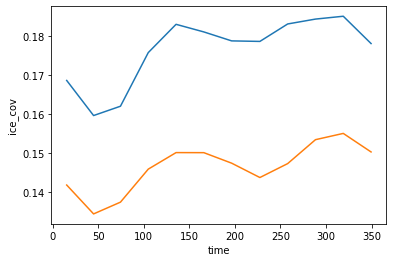

<xarray.DataArray 'ice_cov' (time: 12)>
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)
Coordinates:
  * time     (time) float64 15.5 45.0 74.5 105.0 ... 258.0 288.5 319.0 349.5
<xarray.DataArray 'ice_cov' (time: 12)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)
Coordinates:
  * time     (time) float64 15.5 45.0 74.5 105.0 ... 258.0 288.5 319.0 349.5
<xarray.DataArray 'ice_cov' (time: 12)>
array([1.        , 1.        , 1.        , 1.        , 0.9999993 ,
       1.        , 1.        , 0.99999994, 0.9999995 , 1.        ,
       1.        , 1.        ], dtype=float32)
Coordinates:
  * time     (time) float64 15.5 45.0 74.5 105.0 ... 258.0 288.5 319.0 349.5
<xarray.DataArray 'ice_cov' (time: 12)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)
Coordinates:
  * time     (time) float64 15.5 45.0 74.5 105.0 ... 258.0 288.5 319.0 349.5


In [62]:
## quick check no grid weighting
lgm_bc_final_prediddle.ice_cov.mean(dim=('lat','lon')).plot()
holo_bc_final_prediddle.ice_cov.mean(dim=('lat','lon')).plot()
plt.show()

print(lgm_bc_final_prediddle.ice_cov.max(dim=('lat','lon')))
print(lgm_bc_final_prediddle.ice_cov.min(dim=('lat','lon')))

print(holo_bc_final_prediddle.ice_cov.max(dim=('lat','lon')))
print(holo_bc_final_prediddle.ice_cov.min(dim=('lat','lon')))

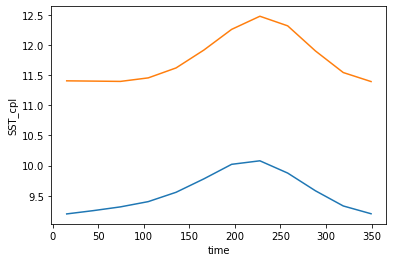

<xarray.DataArray 'SST_cpl' (time: 12)>
array([27.314154, 27.264605, 27.502071, 27.61579 , 27.788998, 28.038578,
       29.626896, 29.944466, 28.678154, 27.563766, 27.357542, 26.965052],
      dtype=float32)
Coordinates:
  * time     (time) float64 15.5 45.0 74.5 105.0 ... 258.0 288.5 319.0 349.5
<xarray.DataArray 'SST_cpl' (time: 12)>
array([-1.8, -1.8, -1.8, -1.8, -1.8, -1.8, -1.8, -1.8, -1.8, -1.8, -1.8,
       -1.8], dtype=float32)
Coordinates:
  * time     (time) float64 15.5 45.0 74.5 105.0 ... 258.0 288.5 319.0 349.5
<xarray.DataArray 'SST_cpl' (time: 12)>
array([30.53999 , 30.512833, 30.623287, 31.408987, 31.840485, 33.226532,
       35.779373, 36.401924, 35.203484, 32.78963 , 30.999126, 30.869   ],
      dtype=float32)
Coordinates:
  * time     (time) float64 15.5 45.0 74.5 105.0 ... 258.0 288.5 319.0 349.5
<xarray.DataArray 'SST_cpl' (time: 12)>
array([-1.8, -1.8, -1.8, -1.8, -1.8, -1.8, -1.8, -1.8, -1.8, -1.8, -1.8,
       -1.8], dtype=float32)
Coordinates:
  * time     (tim

In [63]:
lgm_bc_final_prediddle.SST_cpl.mean(dim=('lat','lon')).plot()
holo_bc_final_prediddle.SST_cpl.mean(dim=('lat','lon')).plot()
plt.show()

print(lgm_bc_final_prediddle.SST_cpl.max(dim=('lat','lon')))
print(lgm_bc_final_prediddle.SST_cpl.min(dim=('lat','lon')))

print(holo_bc_final_prediddle.SST_cpl.max(dim=('lat','lon')))
print(holo_bc_final_prediddle.SST_cpl.min(dim=('lat','lon')))

## Save prediddled files

In [44]:
# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
# fname = 'lgm_bc_final_prediddle.nc'
# lgm_bc_final_prediddle.to_netcdf(savepath + fname)
# print('finished saving')

finished saving


In [46]:
# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
# fname = 'holo_bc_final_prediddle.nc'
# holo_bc_final_prediddle.to_netcdf(savepath + fname)
# print('finished saving')

finished saving


# Dummy data prep for bcgen